In [1]:
# Standard libraries
import json
import re
import warnings
warnings.filterwarnings("ignore")

# Third-party libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Configuration
sns.set_theme()

## **Exploratory Data Analysis (EDA)**

In [2]:
# Data ingestion
data = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(data)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [3]:
print(
    f"{df.description.nunique() = }",
    f"\n{df.tag.nunique() = }",
    f"\n{df.tag.value_counts()}",
    f"\n{df.created_on.nunique() = }",
)

df.description.nunique() = 764 
df.tag.nunique() = 4 
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: tag, dtype: int64 
df.created_on.nunique() = 764


In [4]:
# Splitting data into training

## Setting aside 20% of data to later be split between the test and validation
## sets
rem_size = 0.2
test_size = 0.5

train_df, rem_df = train_test_split(df, test_size=rem_size, random_state=0, stratify=df.tag)


# Splitting the rem_df to create our test and validation sets
val_df, test_df = train_test_split(rem_df, test_size=test_size, random_state=0, stratify=rem_df.tag)

In [5]:
print(
    f"Shape of train_df {train_df.shape}"
    f"\nShape of val_df {val_df.shape}"
    f"\nShape of test_df {test_df.shape}"
)

Shape of train_df (611, 5)
Shape of val_df (76, 5)
Shape of test_df (77, 5)


In [7]:
print(
    "Count of 'Tags':"
    f"\n{df.tag.value_counts()}",
)

Count of 'Tags':
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: tag, dtype: int64


In [8]:
# Get the tag counts
tag_counts = df.tag.value_counts()

# Separate values and tags
tags = tag_counts.index
tag_values = tag_counts.values

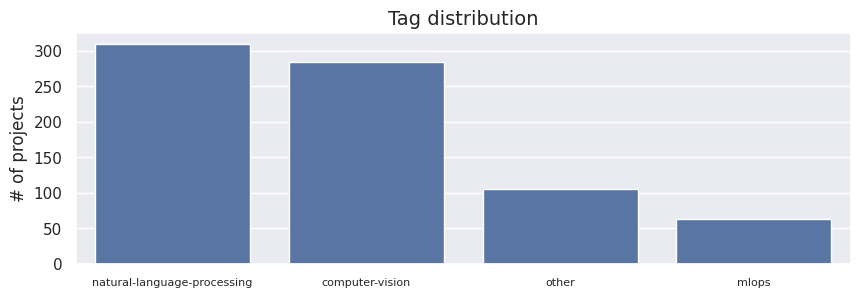

In [9]:
# Plot tag frequencies
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_values))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

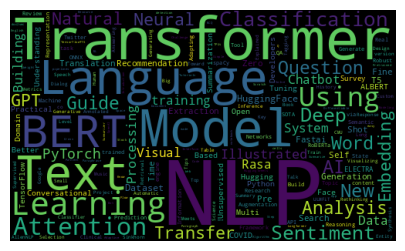

In [10]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

## **Feature Engineering**

In [17]:
# Input
df['text'] = df.title + " " + df.description

df

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,Awesome Monte Carlo Tree Search A curated list...
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other,"AttentionWalk A PyTorch Implementation of ""Wat..."
...,...,...,...,...,...,...
759,2431,2020-10-05 12:36:02,A Survey of the State of Explainable AI for NLP,Overview of the operations and explainability ...,natural-language-processing,A Survey of the State of Explainable AI for NL...
760,2432,2020-10-05 13:09:58,Topic Modeling with BERT,Leveraging 🤗 Transformers and a class-based TF...,natural-language-processing,Topic Modeling with BERT Leveraging 🤗 Transfor...
761,2434,2020-10-06 02:13:01,OpenMMLab Computer Vision,MMCV is a python library for CV research and s...,computer-vision,OpenMMLab Computer Vision MMCV is a python lib...
762,2436,2020-10-06 13:29:44,Machine Learning Methods Explained (+ Examples),Most common techniques used in data science pr...,other,Machine Learning Methods Explained (+ Examples...


In [18]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [19]:
# Apply clean_text function to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)

In [21]:
print (f"{original_df.text.values[2]}\n{df.text.values[2]}")

Awesome Graph Classification A collection of important graph embedding, classification and representation learning papers with implementations.
awesome graph classification collection important graph embedding classification representation learning papers implementations
